In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

fn = 'data/test/test_382cedb7-3579-4b3f-b533-1fab36d5a3f2_2025.01_18.nc'
ds = nc.Dataset(fn)

ModuleNotFoundError: No module named 'matplotlib'

Load data set and libraries.

In [3]:
for dim in ds.dimensions.values():
    print(dim)

"<class 'netCDF4.Dimension'>" (unlimited): name = 'time', size = 730
"<class 'netCDF4.Dimension'>": name = 'lon', size = 280
"<class 'netCDF4.Dimension'>": name = 'lat', size = 144


In [4]:
for var in ds.variables.values():
    print(var)

<class 'netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    units: days since 1978-12-31 0:0:0
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (730,)
filling off
<class 'netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: lon
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (280,)
filling off
<class 'netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: lat
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (144,)
filling off
<class 'netCDF4.Variable'>
float32 AirTemperatureMean(time, lat, lon)
    units: degrees
    _FillValue: -999.0
    missing_value: -999.0
unlimited dimensions: time
current shape = (730, 144, 280)
filling off


These are the details of our dataset:
time: This is measured in days since 1978-12-31 0:0:0. We can view the value with ds['time'][t]
longitude: This is just the longitude of the grid point. We can view the value with ds['lon'][x]
latitude: This is just the latitude of the grid point. We can view the value with ds['lat'][y]

These values are the dimensions of the dataset, (time, lon, lat) -> feature value

We are testing with the average air temperature:

mean_temp = ds['AirTemperatureMean'][t][x][y]



In [5]:
x = 0
lat = []
lon = []
for y in range(len(ds['AirTemperatureMean'][x])):
    for v in range(len(ds['AirTemperatureMean'][x][y])):
        val = ds['AirTemperatureMean'][x][y][v]
        if val is not np.ma.masked:
            lat.append(ds['lat'][y])
            lon.append(ds['lon'][v])
            print(f'({ds['time'][x]}, {ds['lat'][y]}, {ds['lon'][v]}) -> {val}')

(8037.0, 26.862311, 19.233466999999997) -> 17.15387535095215
(8037.0, 26.862311, 19.551088) -> 17.19729995727539
(8037.0, 26.862311, 19.868708999999996) -> 17.204727172851562
(8037.0, 26.862311, 20.186329999999998) -> 17.35015106201172
(8037.0, 26.862311, 20.503951) -> 17.5855770111084
(8037.0, 26.862311, 20.821571999999996) -> 17.587003707885742
(8037.0, 26.862311, 21.139193) -> 17.630428314208984
(8037.0, 26.862311, 21.456813999999994) -> 17.745853424072266
(8037.0, 26.862311, 21.774434999999997) -> 17.843278884887695
(8037.0, 26.862311, 22.092056) -> 17.86870574951172
(8037.0, 26.862311, 22.409676999999995) -> 17.900131225585938
(8037.0, 26.862311, 22.727297999999998) -> 17.709556579589844
(8037.0, 26.862311, 23.044919) -> 17.554981231689453
(8037.0, 26.862311, 23.362539999999996) -> 17.466407775878906
(8037.0, 26.862311, 24.950644999999994) -> 17.43753433227539
(8037.0, 26.862311, 25.268265999999997) -> 17.834959030151367
(8037.0, 26.862311, 25.585887) -> 17.84238624572754
(8037.0,

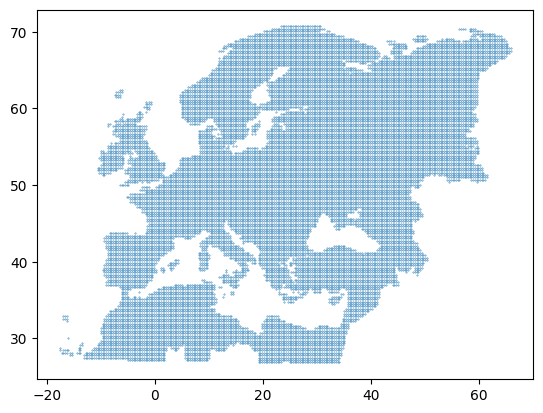

In [6]:
# kind of see a map of europe lol
plt.scatter(lon, lat, s=0.1)
plt.show()

With this we can think of how to map other data points to these grid points, do we use the closest grid point to map that data?
Or is the data average calculated in the square between points?

Lets calculate the closest gridpoint to the csv data we have.

Do this by loading the csv data and calculating a distance matrix between the points in the lat/lon arrays? Then take the min and see what happens, if multiple wosis datapoints map to a point we will take the average of them.

In [7]:
import pandas as pd

fn_wosis = './data/wosis_latest/wosis_latest_orgc.csv'
wosis = pd.read_csv(fn_wosis)

wosis

,X,Y,profile_id,layer_id,profile_code,layer_name,upper_depth,lower_depth,organic_surface,value,method_options,value_avg,dataset_id,country_name,positional_uncertainty,region,continent,date,licence
0,5.041940,46.659943,1006364,3426478,1186,NaN,0,25,0,{11.111},"{""sample pretreatment = [ sieved over 2 mm sie...",11.111,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2003-4-4,"Attribution 4.0 International (CC BY 4.0), htt..."
1,4.832972,46.664703,1006363,3426476,1185,NaN,0,20,0,{29.905},"{""sample pretreatment = [ sieved over 2 mm sie...",29.905,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2003-3-28,"Attribution 4.0 International (CC BY 4.0), htt..."
2,4.832972,46.664703,1006363,3426477,1185,NaN,25,50,0,{8.54},"{""sample pretreatment = [ sieved over 2 mm sie...",8.540,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2003-3-28,"Attribution 4.0 International (CC BY 4.0), htt..."
3,5.020531,46.228349,1006493,3426724,1310,NaN,0,25,0,{14.2},"{""sample pretreatment = [ sieved over 2 mm sie...",14.200,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2007-10-8,"Attribution 4.0 International (CC BY 4.0), htt..."
4,5.197629,45.647835,1006655,3427031,1475,NaN,0,30,0,{25.9},"{""sample pretreatment = [ sieved over 2 mm sie...",25.900,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2007-5-23,"Attribution 4.0 International (CC BY 4.0), htt..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,4.361099,45.234109,1006781,3427268,1596,NaN,0,30,0,{28},"{""sample pretreatment = [ sieved over 2 mm sie...",28.000,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2007-4-12,"Attribution 4.0 International (CC BY 4.0), htt..."
278,3.949590,45.096876,1006823,3427352,1635,NaN,36,56,0,{6.55},"{""sample pretreatment = [ sieved over 2 mm sie...",6.550,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2007-3-19,"Attribution 4.0 International (CC BY 4.0), htt..."
279,4.762033,45.082094,1006827,3427360,1639,NaN,30,50,0,{17.9},"{""sample pretreatment = [ sieved over 2 mm sie...",17.900,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2007-1-29,"Attribution 4.0 International (CC BY 4.0), htt..."
280,3.945431,44.952984,1006866,3427435,1676,NaN,30,50,0,{8.54},"{""sample pretreatment = [ sieved over 2 mm sie...",8.540,FR-RMQS-2000,France,1 km - 10 km,Western Europe,Europe,2007-4-3,"Attribution 4.0 International (CC BY 4.0), htt..."


So we map things by the X and Y: X = lon, Y = lat

In [8]:
# matrix lon, lat matrix of non masked values
jrc_XY = np.array([lon, lat]).T

In [27]:
# calc distance from wosis pts to each jrc pt, might take a while
from scipy.spatial.distance import cdist
dist = cdist(wosis[['X', 'Y']], jrc_XY)
print(wosis[['X', 'Y']].shape)
print(jrc_XY.shape)
print(dist.shape)

count = {}
for d in dist:
    i = d.argmin()
    if i in count:
        count[i] += 1
    else:
        count[i] = 0

print(len(count))
for k, v in count.items():
    print(jrc_XY[k])
# print(jrc_XY[dist[0].argmin()])
# print(jrc_XY[dist[1].argmin()])
# print(jrc_XY[dist[2].argmin()])
# print(wosis[['X', 'Y']])

(282, 2)
(19523, 2)
(282, 19523)
49
[ 4.940522 46.554813]
[ 4.940522 46.237192]
[ 5.258143 45.60195 ]
[ 4.940522 45.60195 ]
[ 4.940522 45.919571]
[ 5.575764 46.237192]
[ 5.575764 46.554813]
[ 5.258143 45.919571]
[ 5.575764 46.872434]
[ 5.258143 46.237192]
[ 4.940522 46.872434]
[ 5.575764 45.919571]
[ 4.30528 45.60195]
[ 3.670038 45.284329]
[ 4.940522 44.966708]
[ 4.622901 44.966708]
[ 4.622901 46.554813]
[ 4.622901 46.872434]
[ 5.258143 45.284329]
[ 4.30528  45.919571]
[ 4.622901 45.60195 ]
[ 4.30528  46.554813]
[ 5.575764 44.966708]
[ 3.987659 45.60195 ]
[ 4.30528  44.966708]
[ 3.987659 46.237192]
[ 3.987659 46.554813]
[ 3.987659 46.872434]
[ 5.258143 44.966708]
[ 4.940522 45.284329]
[ 5.575764 45.284329]
[ 3.670038 44.966708]
[ 3.670038 45.60195 ]
[ 4.30528  45.284329]
[ 5.575764 45.60195 ]
[ 3.987659 45.284329]
[ 4.622901 45.919571]
[ 4.30528  46.872434]
[ 3.987659 45.919571]
[ 3.670038 46.554813]
[ 4.622901 46.237192]
[ 3.670038 46.237192]
[ 4.30528  46.237192]
[ 3.670038 45.919571

In [27]:
import requests

req = 'https://rest.isric.org/soilgrids/v2.0/properties/query?lon=5.041940&lat=46.659943&property=bdod&property=cec&property=cfvo&property=clay&property=nitrogen&property=ocd&property=ocs&property=phh2o&property=sand&property=silt&property=soc&property=wv0010&property=wv0033&property=wv1500&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=Q0.5&value=Q0.05&value=Q0.95&value=mean&value=uncertainty'
small_req = 'https://rest.isric.org/soilgrids/v2.0/properties/query?lon=5.041940&lat=46.659943&property=nitrogen&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=mean'
r = requests.get(small_req)

In [37]:
r.json()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [5.04194, 46.659943]},
 'properties': {'layers': [{'name': 'nitrogen',
    'unit_measure': {'d_factor': 100,
     'mapped_units': 'cg/kg',
     'target_units': 'g/kg',
     'uncertainty_unit': ''},
    'depths': [{'range': {'top_depth': 0,
       'bottom_depth': 5,
       'unit_depth': 'cm'},
      'label': '0-5cm',
      'values': {'mean': 605}},
     {'range': {'top_depth': 5, 'bottom_depth': 15, 'unit_depth': 'cm'},
      'label': '5-15cm',
      'values': {'mean': 220}},
     {'range': {'top_depth': 15, 'bottom_depth': 30, 'unit_depth': 'cm'},
      'label': '15-30cm',
      'values': {'mean': 216}},
     {'range': {'top_depth': 30, 'bottom_depth': 60, 'unit_depth': 'cm'},
      'label': '30-60cm',
      'values': {'mean': 208}},
     {'range': {'top_depth': 60, 'bottom_depth': 100, 'unit_depth': 'cm'},
      'label': '60-100cm',
      'values': {'mean': 153}},
     {'range': {'top_depth': 100, 'bottom_depth': 200, '

Calculating the new longitudes going 25km east:

the km to change lon by 1 degree at lat x, km_1_degree = (pi/180) * (radius of earth) * cos(x in radians) <- km/degree
pi/180 converts the radians to degrees 

In [13]:
import math

r_earth = 6371
pi_180 = math.pi / 180

# test calculation with latitude
lat_rads = math.radians(46.659943)

denom = pi_180 * r_earth * math.cos(lat_rads)

def delta_lon(d_km, latitude):
    return d_km / (pi_180 * r_earth * math.cos(math.radians(latitude)))

In [ ]:
delta_lon(25, 46.659943)

0.32758496253600805

In [55]:
small_req_moved = f'https://rest.isric.org/soilgrids/v2.0/properties/query?lon={5.041940+0.0045}&lat=46.659943&property=nitrogen&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=mean'

r2 = requests.get(small_req_moved)

In [56]:
r2.json()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [5.0464400000000005, 46.659943]},
 'properties': {'layers': [{'name': 'nitrogen',
    'unit_measure': {'d_factor': 100,
     'mapped_units': 'cg/kg',
     'target_units': 'g/kg',
     'uncertainty_unit': ''},
    'depths': [{'range': {'top_depth': 0,
       'bottom_depth': 5,
       'unit_depth': 'cm'},
      'label': '0-5cm',
      'values': {'mean': 611}},
     {'range': {'top_depth': 5, 'bottom_depth': 15, 'unit_depth': 'cm'},
      'label': '5-15cm',
      'values': {'mean': 212}},
     {'range': {'top_depth': 15, 'bottom_depth': 30, 'unit_depth': 'cm'},
      'label': '15-30cm',
      'values': {'mean': 235}},
     {'range': {'top_depth': 30, 'bottom_depth': 60, 'unit_depth': 'cm'},
      'label': '30-60cm',
      'values': {'mean': 219}},
     {'range': {'top_depth': 60, 'bottom_depth': 100, 'unit_depth': 'cm'},
      'label': '60-100cm',
      'values': {'mean': 186}},
     {'range': {'top_depth': 100, 'bottom_dep

Now to calculate the latitude change!
This one is much more simple in comparison, it doesn't rely on the lon!

In [14]:
def delta_lat(d_km):
    return d_km / (pi_180 * r_earth)

So we can see that it changes when we move by 25 km east, so we need to do a 250km x 250km search and average the results,
assuming the point is in the middle we go west by 125 km and south by 125 km

In [53]:
from itertools import product

def calc_grid_pts(latitude, longitude):
    # the jrc  is 25km x 25km resolution
    # soilgrid is 250m x 250m resolution
    # == meaning 25/0.25 = 100 => 100 x 100 (or 10000 soil grid pts to average per jrc pt... YIKES)

    # calc corner coord of grid
    start_lat = latitude - delta_lat(12.5)
    end_lat = latitude + delta_lat(12.5)
    start_lon = longitude - delta_lon(12.5, start_lat)

    # calc all lon deltas, lon delta relies on lat values
    lat_delta = delta_lat(0.25) # 250m delta, will stay constant
    lats = np.array([(start_lat + (x * lat_delta)) for x in range(100)])

    # delta for going 250m, it depends on the lats
    lon_deltas = np.array([delta_lon(0.25, x) for x in lats])

    lons = np.empty((len(lats), len(lon_deltas)))
    for lon_delta, i in zip(lon_deltas, range(len(lons))):
        lons[i] = np.array([(start_lon + (x * lon_delta)) for x in range(100)])

    coords = np.empty(shape=(0, 2))
    for lat, lon in zip(lats, lons):
        coords = np.concatenate((coords, np.array(list(product([lat], lon)))))
    return coords

def bulk_calc_grid_pts(grid):
    coords = []
    for lat, lon in grid:
        coords.append(calc_grid_pts(lat, lon))
    return np.array(coords)

def get_request_property_vals(data):
    layers = []
    for layer in data['properties']['layers']:
        l_values = []
        for depth in layer['depths']:
            v = depth['values']['mean']
            if v:
                l_values.append(depth['values']['mean'])
            else:
                break
        if v:
            layers.append(np.array(l_values))
            
    return np.array(layers)

def avg_250_grid(coords, request):
    # (lat, lon) starting pos
    # request, w/o the lat & lon
    grid_vals = []
    for lat, lon in coords:
        r = requests.get(request+f'&lon={lon}&lat={lat}')
        data = r.json()
        print(data)
        grid_vals.append(get_request_property_vals(data))

    return np.array(grid_vals)

In [ ]:
import timeit

timeit.timeit(lambda: calc_grid_pts(46.659943, 5.04194), number=40320) # it do be takin a while, but! it precalcs everything so its not so bad?

99.24011109996354

In [17]:
full_coords = bulk_calc_grid_pts(jrc_XY)

In [57]:
q = 'https://rest.isric.org/soilgrids/v2.0/properties/query?property=nitrogen&property=phh2o&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=mean'
data = avg_250_grid(coords=full_coords[0], request=q)

{'detail': '5 per 1 minute'}


KeyError: 'properties'

array([[ 58,  69, 117, 183, 220, 238],
       [ 83,  83,  83,  81,  81,  81]])